In [1]:
import os
import re
import pandas as pd
import numpy as np
import patsy

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from scipy import stats

In [2]:
data_unstructured = pd.read_csv("data.csv")
data = data_unstructured
data.drop("Id",axis = 1, inplace = True)
data["SalePrice"] = np.log(data["SalePrice"] + 1)
data.rename(columns = {"SalePrice":"log_price"},inplace = True)

In [3]:
print("Number of Features:",len(data.columns) - 1)
print("Number of Observations:",len(data))

Number of Features: 79
Number of Observations: 1460


## I. Preprocessing

In [4]:
missing_data = data.isna().sum().reset_index()
missing_data.columns = ["Feature","# Missing"]
missing_data = missing_data[missing_data["# Missing"] > 0].sort_values(by = "# Missing",ascending=False)
missing_data["% of Observations"] = (missing_data["# Missing"] / len(data)).round(4)
missing_data

,Feature,# Missing,% of Observations
71,PoolQC,1453,0.9952
73,MiscFeature,1406,0.9630
5,Alley,1369,0.9377
72,Fence,1179,0.8075
56,FireplaceQu,690,0.4726
2,LotFrontage,259,0.1774
57,GarageType,81,0.0555
58,GarageYrBlt,81,0.0555
59,GarageFinish,81,0.0555
62,GarageQual,81,0.0555


In [5]:
print("Number of Features with Missing Observations:",len(missing_data))

Number of Features with Missing Observations: 19


**Features with $\geq 80\%$ of missing observations are removed from the design matrix:**
- *PoolQC:* pool quality 
- *MiscFeature:* features not covered in other categories
- *Alley* 
- *Fence:* fence quality

In [6]:
data.drop(["PoolQC","MiscFeature","Alley","Fence"],axis = 1,inplace = True)

**The missing values among the following regressors simply indicate that the property doesn't have a basement, garage, and/or a fireplace:**

- *BsmtQual, BsmtCond, BsmtFinType1, BsmtFinType2, BsmtExposure*
- *GarageCond, GarageQual, GarageFinish, GarageYrBuilt, GarageType*
- *FireplaceQu*

**$NAs$ in *GarageYrBuilt*, the year a garage was built, are replaced with $1$. Categorical variables are imputed with "Not applicable."**

In [7]:
data["GarageYrBlt"].fillna(1,inplace = True)
index = ["GarageCond","GarageQual","GarageFinish",
         "GarageType","BsmtQual","BsmtCond","BsmtFinType1",
         "BsmtFinType2","BsmtExposure","FireplaceQu"]
data[index] = data[index].fillna("Not Applicable")

**Unconditional mean/mode imputations are applied to the following features that are only missing $\leq 0.5\%$:**
- *Electrical*
- *MasVnrType:* masonvy veneer type
- *MasVnrArea:* masonry veneer area in square feet

In [9]:
electrical_mode = stats.mode(data["Electrical"])[0][0]
masvnrtype_mode = stats.mode(data["MasVnrType"])[0][0]
masvnrarea_mean = np.mean(data["MasVnrArea"])

data.fillna({"Electrical":electrical_mode,
             "MasVnrType":masvnrtype_mode,
             "MasVnrArea":masvnrarea_mean},inplace = True)

**Lastly, the linear feet of street connected to the property (*LotFrontage*) is unavailable for $17\%$ of observations. While mean imputation is nonetheless a valid approach, missing *LotFrontage* are instead imputed conditional on lot size:**

$$LotFrontage = \beta_0 + \beta_1 LotArea + e$$

In [10]:
#model fitting
eq = "LotFrontage ~ -1 + LotArea"
y, X = patsy.dmatrices(eq,data,return_type="dataframe")
X = sm.add_constant(X)
ols = sm.OLS(y,X).fit()

#conditional imputation
predictions = ols.predict(sm.add_constant(data.loc[data["LotFrontage"].isna(),"LotArea"]))
data.loc[data["LotFrontage"].isna(),"LotFrontage"] = predictions

**For interpretability, the log transformation is applied to all independent variables measured in square footage:**

In [11]:
features = list(data.columns)

pattern = re.compile(".*(Area|SF|SF1|SF2|Porch)$")
sqf_features = list(filter(pattern.match, features)) 
print(sqf_features)

['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea']


In [12]:
for i in sqf_features:
    data[i] = np.log(data[i] + 1)

**The age of the properties can be obtained by taking the difference between the year they were sold and the year they were built:**

$$Age = YrSold - YearBuilt$$

In [13]:
data["Age"] = data["YrSold"] - data["YearBuilt"]

**Recall that not all properties have a basement, garage, and/or fireplace. They are denoted by "Not Applicable" under the corresponding features that relate to these characteristics. However, it would still be informative to create categorical variables for whether or not a property contains these features:**

In [14]:
def hasX(conditional):
    result = []
    for i in range(0,len(data)):
        if data.loc[i,conditional] == "Not Applicable":
            result.append("No")
        else:
            result.append("Yes")
    return result

data["HasBasement"] = hasX("BsmtCond")
data["HasGarage"] = hasX("GarageCond")
data["HasFireplace"] = hasX("FireplaceQu") 

In [15]:
print("Number of Features:",len(data.columns) - 1)
print("Number of Observations:",len(data))
print("Number of Observations with Missing Data:",data.isna().sum().sum())

Number of Features: 79
Number of Observations: 1460
Number of Observations with Missing Data: 0


**The final step of preprocessing is the conversion of the features to correct data types:**

In [16]:
categorical = ['MSSubClass', 'MSZoning', 'Street','LotShape', 'LandContour', 'Utilities', 
               'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 
               'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 
               'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond','BsmtExposure', 
               'BsmtFinType1', 'BsmtFinType2','Heating', 'HeatingQC','CentralAir', 'Electrical', 
               'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 
               'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition', 'HasBasement', 'HasGarage',
               'HasFireplace']

integers = ['Age','YrSold','MoSold',"Fireplaces",'GarageYrBlt','BsmtFullBath','BsmtHalfBath',
            'FullBath','HalfBath', 'BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','GarageCars',
            'YearRemodAdd','YearBuilt','OverallQual','OverallCond']

for i in data.columns:
    if i in categorical:
        data[i] = data[i].astype("category")
    elif i in integers:
        data[i] = data[i].astype("int")
    else:
        data[i] = data[i].astype("float")

### II. EDA

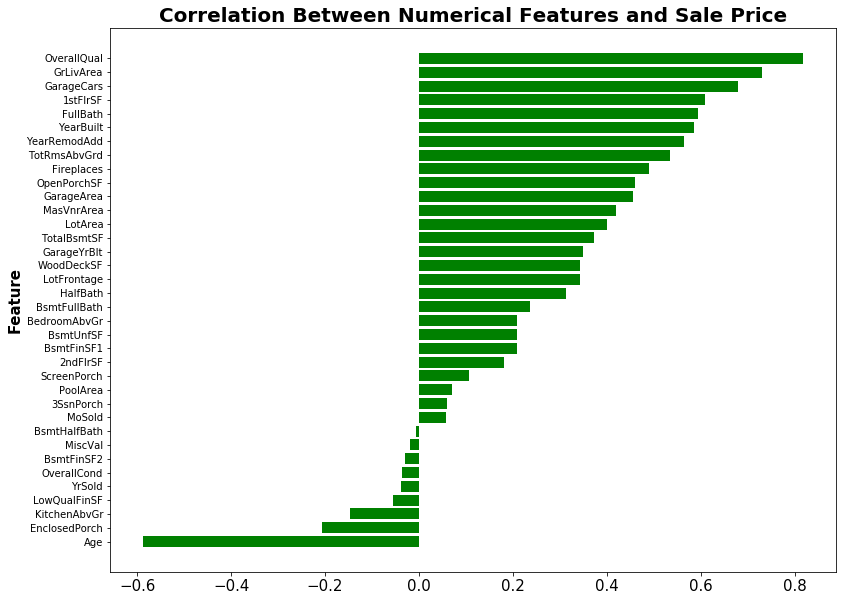

In [17]:
correlations = data.corr()
correlations = correlations["log_price"].reset_index()
correlations.rename(columns = {"index":"Numerical Feature",
                               "log_price":"Correlation"},inplace = True)
correlations = correlations.sort_values(by = "Correlation",ascending = False)[1:]

figure,axis = plt.subplots(figsize = (13,10))
axis.barh(correlations.iloc[:,0],correlations.iloc[:,1],color = "green")
axis.set_title("Correlation Between Numerical Features and Sale Price",fontsize = 20,fontweight = "bold")
axis.set_ylabel(ylabel = "Feature",fontsize = 15,fontweight = "bold")
axis.tick_params(axis = "x", labelsize = 15)
axis.invert_yaxis()